# Problem Transformation - Word2Vec

This notebook discusses Multi-label classificaon methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in [Word2Vec](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from pathlib import Path
from academia_tag_recommender.definitions import MODELS_PATH
from academia_tag_recommender.classifier import Classifier, available_classifier_paths

DATA_FOLDER = Path(MODELS_PATH) / 'classifier' / 'multi-label'
RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.data import documents
from academia_tag_recommender.test_train_data import get_y, get_test_train_data

def get_X():
    return np.vstack([document.text for document in documents])

X_train, X_test, y_train, y_test = get_test_train_data(get_X(), get_y(), scale=False)
print('Train set with shape ', X_train.shape)
print('Test set with shape', X_test.shape)

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Train set with shape  (24812, 1)
Test set with shape (8270, 1)


<a id='data_preparation'/>

## Data Preparation

In [3]:
from nltk.tokenize import sent_tokenize
from academia_tag_recommender.stopwords import stopwordlist
from gensim.utils import simple_preprocess
from gensim.matutils import unitvec
from gensim.models import Word2Vec

def sent2tokens(sentence):
    tokens = []
    for word in simple_preprocess(sentence):
        if word in stopwordlist:
            continue
        tokens.append(word)
    return tokens

def word2tokens(document, flat=True):
    sentences = []
    for sentence in sent_tokenize(document, language='english'):
        sentence = sent2tokens(sentence)
        if flat:
            sentences = sentences + sentence
        else:
            sentences.append(sentence)
    return sentences

class Word2Tok:
    def __init__(self, data, flat=True):
        self.data = data
        self.flat = flat
    
    def __iter__(self):
        for document in self.data:
            sentences = word2tokens(document[0], self.flat)
            if self.flat:
                yield sentences
            else:
                for sentence in sentences:
                    yield sentence
                    
def get_wv(sentences):
    wv = Word2Vec(sentences=sentences, size=100).wv
    wv.init_sims(replace=True)
    return wv
    
# code taken from: https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.word_vec(word, use_norm=True))
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, samples):
    return np.vstack([word_averaging(wv, sample) for sample in samples])

def word2vec(X_train, X_test):
    X_train_word2sen = Word2Tok(X_train, flat=False)
    X_train_word2tok = Word2Tok(X_train)
    X_test_word2tok = Word2Tok(X_test)
    print(list(X_train_word2sen)[:1])
    print(list(X_train_word2tok)[:1])
    print(list(X_test_word2tok)[:1])

    wv = get_wv(X_train_word2sen)
    return word_averaging_list(wv, X_train_word2tok), word_averaging_list(wv, X_test_word2tok)

In [4]:
X_train, X_test = word2vec(X_train, X_test)

[['kind', 'visa', 'required', 'work', 'academia', 'japan']]
[['kind', 'visa', 'required', 'work', 'academia', 'japan', 'title', 'kind', 'visa', 'class', 'apply', 'order', 'work', 'academic', 'japan']]
[['computational', 'chemist', 'online', 'resources', 'available', 'ph', 'level', 'jobs', 'online', 'resources', 'available', 'job', 'search', 'ph', 'level', 'computational', 'chemistry', 'field']]


In [5]:
from academia_tag_recommender.preprocessing_definition import PreprocessingDefinition
preprocessing = PreprocessingDefinition('word2vec', 'basic', 'basic', 'english', '1,1', 'None')

def create_classifier(classifier, name=False):
    clf = Classifier(classifier, preprocessing, name)
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    clf.save('word2vec')
    print('Training: {}s'.format(clf.training_time))
    print('Test: {}s'.format(clf.test_time))
    clf.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [ExtraTreeClassifier](#extratree)
- [KNeighborsClassifier](#kNN)
- [RadiusNeighborsClassifier](#rNN)
- [MLPClassifier](#mlp)
- [RidgeClassifierCV](#ridge)
- [MultioutputClassifier](#multioutput)
- [Classwise Classifier](#classwise)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [6]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 119.90242886543274s
Test: 0.09183120727539062s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.022026347610259022     0.008706166868198308     0.19514913341394596      0.18976017734784364      0.17488762211857736      
micro                                                            0.18154803361656685      0.1871440195280716       0.1843035588027339       
macro                                                            0.08123787318989792      0.08360832756673126      0.08202918489836875      


<a id='extratree'/>

**ExtraTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn.tree.ExtraTreeClassifier)

In [7]:
from sklearn.tree import ExtraTreeClassifier

create_classifier(ExtraTreeClassifier(random_state=RANDOM_STATE), 'ExtraTreeClassifier')

Training: 2.9667911529541016s
Test: 0.10925006866455078s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02280913892954878      0.005441354292623942     0.1633172108020959       0.16047158403869408      0.14771002475960157      
micro                                                            0.15472395472395473      0.16029292107404394      0.15745921293901924      
macro                                                            0.07012622553383456      0.07065717782298701      0.06999606596419115      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 1.8222846984863281s
Test: 151.24322056770325s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013229173295996946     0.05912938331318017      0.3413845223700121       0.1934421604191858       0.23066188748776414      
micro                                                            0.5069389892642053       0.18532522854544584      0.27142406505204864      
macro                                                            0.3028024690711288       0.07520017940914689      0.10646046547168168      


<a id='rNN'/>

**RadiusNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier)

In [9]:
from sklearn.neighbors import RadiusNeighborsClassifier

create_classifier(RadiusNeighborsClassifier(outlier_label='most_frequent'), 'RadiusNeighborsClassifier')

Training: 1.5582070350646973s
Test: 572.8949010372162s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013296633360911348     0.04195888754534462      0.00012091898428053205   2.418379685610641e-05    4.030632809351068e-05    
micro                                                            0.5                      4.786292059541473e-05    9.571667863125148e-05    
macro                                                            0.005263157894736842     5.696058327637275e-06    1.1379800853485064e-05   


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [10]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training: 207.9850161075592s
Test: 0.11623311042785645s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011693502195634187     0.08137847642079807      0.45792825473599347      0.26629383313180166      0.31449022091706497      
micro                                                            0.656129911987108        0.25333843871153017      0.36553867403314916      
macro                                                            0.43783500457602703      0.13986711443447644      0.19036628623637014      


<a id='ridge'/>

**RidgeClassifierCV** [source](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV)

*TODO: implementation needs to be adjusted for different prediction format: `[125 278 302 ...  80  64 158]`*

In [11]:
from sklearn.linear_model import RidgeClassifierCV

#create_classifier(RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]))

<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [12]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 54.4030396938324s
Test: 1.0107793807983398s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011959523961051358     0.07085852478839177      0.3378677952438533       0.17719266424828697      0.21877900616111015      
micro                                                            0.7152222905142389       0.16708945579859283      0.27089314813377824      
macro                                                            0.2426544849367          0.05806705380322248      0.08067633054511861      


In [13]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 43.82354784011841s
Test: 1.0138306617736816s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012161267740087826     0.06928657799274486      0.31830511890366786      0.16913744457879887      0.20750762941210343      
micro                                                            0.6823385118560916       0.15976642894749438      0.25891021911964324      
macro                                                            0.2425392422294449       0.04837410106522831      0.07018892854052391      


<a id='classwise'/>

**Classwise Classifier**

In [14]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score

scorer = make_scorer(accuracy_score)

In [15]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption

classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]}),
                      ClassifierOption(LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], random_state=RANDOM_STATE, max_iter=2000, scoring=scorer))]
                      #ClassifierOption(RandomForestClassifier(random_state=RANDOM_STATE))]

#create_classifier(ClasswiseClassifier(classifier_options), 'ClasswiseClassifier')

<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [16]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Training: 87.26375031471252s
Test: 3.25632643699646s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011836059313943869     0.07666263603385731      0.39153567110036275      0.20958484482063683      0.25675850751425117      
micro                                                            0.6926952141057935       0.19743454745608577      0.3072854588796186       
macro                                                            0.2789734648789495       0.07256284805173907      0.09907459906965878      


In [17]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Training: 97.41784334182739s
Test: 3.963008403778076s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012114172977789092     0.07061668681983072      0.35749496170898837      0.19343611446997178      0.23546947275484154      
micro                                                            0.6590208832591579       0.18427224429234673      0.2880119693285955       
macro                                                            0.2542586191270007       0.055315131886986425     0.07866962638026673      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [18]:
from skmultilearn.problem_transform import LabelPowerset

#create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

In [19]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [BRkNNa](#brknna)
- [BRkNNb](#brknnb)
- [MLTSVM](#mltsvm)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [20]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Training: 599.0262310504913s
Test: 149.98436188697815s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012812957423789219     0.06118500604594922      0.3504635227730754       0.19473196291817818      0.23427131916853802      
micro                                                            0.5542857142857143       0.18570813191020916      0.27820600150575414      
macro                                                            0.30946186074002385      0.08702565098664423      0.12087566288129213      


<a id='brknna'/>

**BRkNNa** [source](http://scikit.ml/api/skmultilearn.adapt.brknn.html#skmultilearn.adapt.brknn.BRkNNaClassifier)

> BRkNN is an adaptation of the kNN algorithm for multilabel classification that is conceptually equivalent to using the popular Binary Relevance problem transformation method in conjunction with the kNN algorithm, but |L| times faster. [L = labels]
<cite>[Spyromitros et al., 2008][2]</cite>

[2]: https://doi.org/10.1007/978-3-540-87881-0_40


>  This version of the classifier assigns the labels that are assigned to at least half of the neighbors.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.adapt.brknn.html#skmultilearn.adapt.BRkNNaClassifier

In [21]:
from skmultilearn.adapt import BRkNNaClassifier

create_classifier(BRkNNaClassifier(), 'BRkNNaClassifier')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Training: 1.7129275798797607s
Test: 78.55821061134338s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01263157894736842      0.05985489721886336      0.27678355501813784      0.1356307940346634       0.17215322162722405      
micro                                                            0.6217664879981356       0.1276982721485665       0.2118805590851334       
macro                                                            0.27157513979422726      0.04266567498344265      0.06361812724081028      


<a id='brknnb'/>

**BRkNNb** [source](http://scikit.ml/api/skmultilearn.adapt.brknn.html#skmultilearn.adapt.brknn.BRkNNbClassifier)

>  This version of the classifier assigns the most popular m labels of the neighbors, where m is the average number of labels assigned to the object’s neighbors.
<cite>[skmultilearn][4]</cite>

[4]: http://scikit.ml/api/skmultilearn.adapt.brknn.html#skmultilearn.adapt.BRkNNbClassifier

In [22]:
from skmultilearn.adapt import BRkNNbClassifier

create_classifier(BRkNNbClassifier(), 'BRkNNbClassifier')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Training: 1.24251389503479s
Test: 86.27474236488342s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02647743906319608      0.0020556227327690447    0.020082627972591697     0.01781338170092705      0.01807623654056544      
micro                                                            0.017113546281184427     0.017565691858517207     0.01733667154801833      
macro                                                            0.00025272962157138685   0.011773879142300195     0.000491381283190558     


<a id='mltsvm'/>

**MLTSVM** [source](http://scikit.ml/api/skmultilearn.adapt.mltsvm.html#skmultilearn.adapt.MLTSVM)

<cite>[Chen et al., 2016][5]</cite>

> Twin multi-Label Support Vector Machines
<cite>[skmultilearn][6]</cite>

[5]: https://doi.org/10.1016/j.patcog.2015.10.008
[6]: http://scikit.ml/api/skmultilearn.adapt.mltsvm.html#skmultilearn.adapt.MLTSVM

In [23]:
from skmultilearn.adapt import MLTSVM

# TODO(FIX): executes with error
#create_classifier(MLTSVM(c_k = 2**-1), 'MLTSVM()')

<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [24]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Training: 72.33172702789307s
Test: 388.9709334373474s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017299051740596958     0.038331318016928656     0.41152362683036986      0.308341394598952        0.31272628588255214      
micro                                                            0.3308590178043139       0.29440482458239603      0.31156924323776725      
macro                                                            0.19017220969531395      0.14222464107285035      0.14686547474744088      


<a id='ensembles'/>

### Ensembles

- [ExtraTreesClassifier](#extra_trees)
- [RandomForestClassifier](#random_forest)
- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='extra_trees'/>

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

#create_classifier(ExtraTreesClassifier(random_state=RANDOM_STATE))

<a id='random_forest'/>

**RandomForestClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#create_classifier(RandomForestClassifier(random_state=RANDOM_STATE))

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [6]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
))

Training: 393.1392753124237s
Test: 236.7738344669342s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012067078215490358     0.0660217654171705       0.31248488512696493      0.15767029423619505      0.197795819657972        
micro                                                            0.7240654205607476       0.1484266487858614       0.2463531936881434       
macro                                                            0.15793654639478447      0.04075952756920866      0.0572357077557725       


In [7]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
))

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Training: 427.99807834625244s
Test: 246.62429332733154s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012023801947432062     0.06964933494558646      0.3490810157194679       0.18804312777106005      0.22893351375213528      
micro                                                            0.6823356591994124       0.17797787250347238      0.2823171889838556       
macro                                                            0.2714944545817111       0.058712864366452774     0.08459201692090845      


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [8]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)))

C:\Users\Monique\anaconda3\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(label_sets)


Training: 100.26952195167542s
Test: 81.44286227226257s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012057531979889263     0.06783555018137848      0.3202438532849658       0.16345425231761387      0.20406258996948237      
micro                                                            0.717142215232532        0.1528808850998611       0.2520331622581919       
macro                                                            0.1735312216823475       0.04305726823472033      0.06002082096245251      


In [9]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)))

C:\Users\Monique\anaconda3\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(label_sets)
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfg

Training: 157.94156432151794s
Test: 79.75893187522888s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012053077069942086     0.06952841596130592      0.34966344216041917      0.18867593712212816      0.22964031400548932      
micro                                                            0.6755973931933381       0.17874419272953684      0.2826951482786047       
macro                                                            0.26831557992030053      0.059367196487087874     0.08526973417312426      


***Clustering***

In [18]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [19]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [20]:
clusterer_igraph = get_clusterer()

190 labels, 7741 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [21]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 83.01191329956055s
Test: 9.457564353942871s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01211862788773627      0.06940749697702539      0.3472974607013301       0.18654373236598146      0.22731809370261608      
micro                                                            0.6664854087366322       0.17610996695244024      0.2786028186088801       
macro                                                            0.24113069279434426      0.05189939528345516      0.07397897489113042      


In [22]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

C:\Users\Monique\anaconda3\lib\site-packages\skmultilearn\cluster\igraph.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(


Training: 106.8297369480133s
Test: 8.09552264213562s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011874244256348247     0.07424425634824668      0.37521160822249094      0.2004191858121725       0.24526688547244777      
micro                                                            0.6965834661001947       0.18846688059772979      0.296667671893848        
macro                                                            0.26135523354950596      0.06752572981706095      0.09295021104478912      


<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [23]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

C:\Users\Monique\anaconda3\lib\site-packages\skmultilearn\cluster\igraph.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(
C:\Users\Monique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training: 83.75277638435364s
Test: 3.5935516357421875s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01211862788773627      0.06940749697702539      0.3472974607013301       0.18654373236598146      0.22731809370261608      
micro                                                            0.6664854087366322       0.17610996695244024      0.2786028186088801       
macro                                                            0.24113069279434426      0.05189939528345516      0.07397897489113042      


In [24]:
create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

C:\Users\Monique\anaconda3\lib\site-packages\skmultilearn\cluster\igraph.py:190: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(


Training: 106.98283767700195s
Test: 3.480724573135376s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011874244256348247     0.07424425634824668      0.37521160822249094      0.2004191858121725       0.24526688547244777      
micro                                                            0.6965834661001947       0.18846688059772979      0.296667671893848        
macro                                                            0.26135523354950596      0.06752572981706095      0.09295021104478912      


<a id='evaluation'/>

## Evaluation

In [6]:
paths = available_classifier_paths('word2vec')

In [7]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    evals.append([str(clf), evaluation])

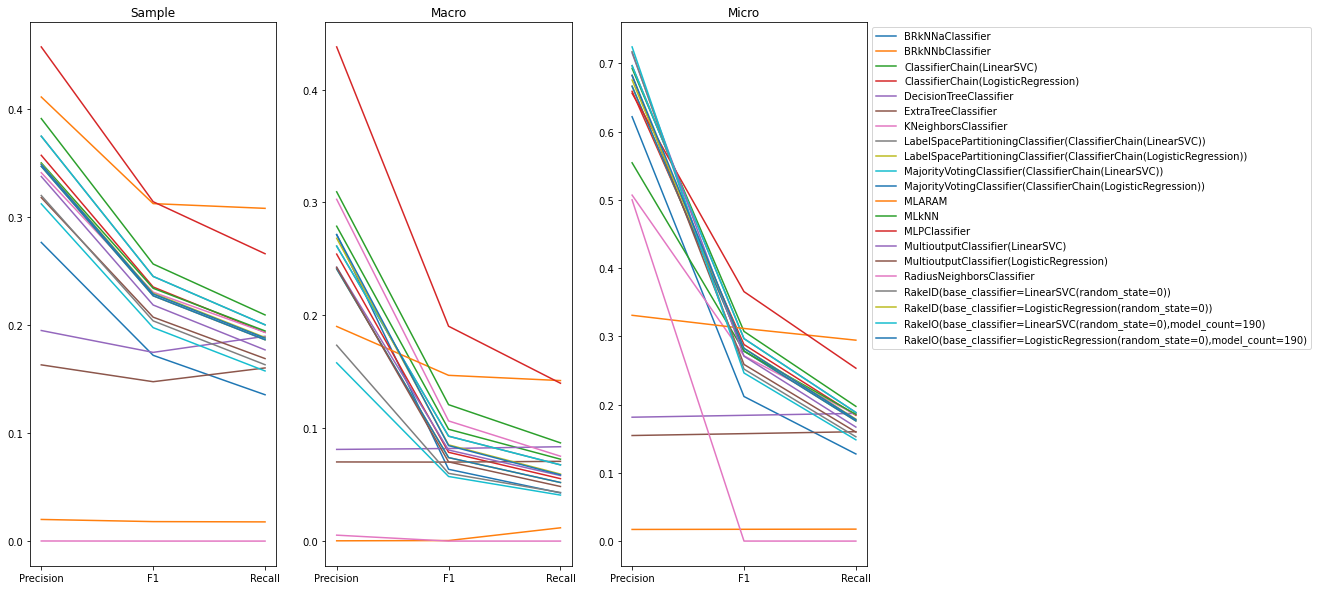

In [8]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [9]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.sum(), reverse=True)[:3]

In [10]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [12]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(X_test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

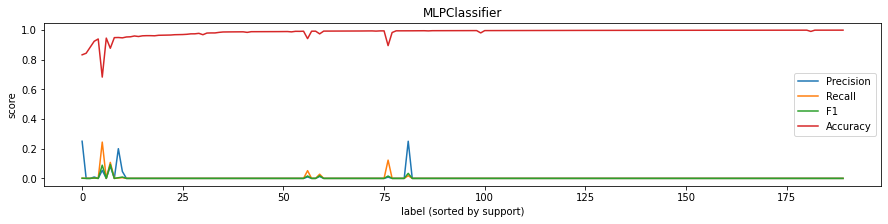

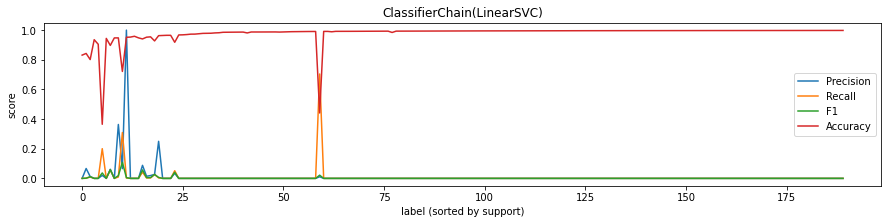

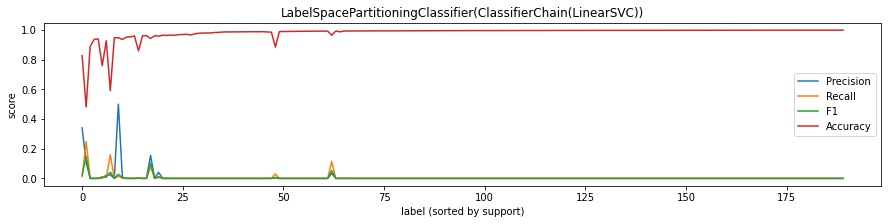

In [14]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()